In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


# Imports

In [4]:
from typing import Dict, Callable, List
from importlib import reload
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

from general.nn.observables import CalculateAndLogMetrics
import deep_morpho.observables.save_loss as save_loss
import deep_morpho.observables.plot_lui_parameters as plp
import deep_morpho.observables.plot_pred as plot_pred 
import deep_morpho.observables.convergence_steps as convergence_steps 
import deep_morpho.observables as obs
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.multi_rect_dataset as mrd
import deep_morpho.models.lui as lui 
from general.nn.pytorch_lightning_module.obs_lightning_module import NetLightning
from deep_morpho.metrics import dice
import general.array_morphology as am
from general.structuring_elements import *
import deep_morpho.morp_operations as mo


def reload_modules():
    for modl in [save_loss, plp, plot_pred, convergence_steps, obs, gfo3, mrd, lui, am, mo]:
        reload(modl)
        
print("Done")

Done


##### Fonctions

In [3]:
def intersection(ars, axis=-1):
    return ars.sum(axis) == ars.shape[axis]

def union(ars, axis=-1):
    return ars.sum(axis) > 0

def fn_chans(ar, fn, chans='all'):
    if chans == 'all':
        chans = range(ar.shape[-1])
    return torch.tensor(fn(np.stack([ar[..., chan] for chan in chans], axis=-1)))

def intersection_chans(ar, chans='all'):
    return fn_chans(ar, intersection, chans)

def union_chans(ar, chans='all'):
    return fn_chans(ar, union, chans)

# Sandbox

In [21]:
reload_modules()

dataloader = mrd.InputOutputGeneratorDataset.get_loader(
    batch_size=32, n_inputs=10000, random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={
        "size": (50, 50, 3),
        "max_shape": (50, 50),
        "n_shapes": 1,
        "p_invert": 0,
        "n_holes": 0,
        "noise_proba": 0
    }, morp_operation=lambda x: union_chans(x, chans=[0, 1])
)

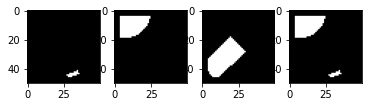

In [23]:
imgs, outs = next(iter(dataloader))
img, out = imgs[0], outs[0]

fig, axs = plt.subplots(1, img.shape[-1] + 1)
for idx in range(img.shape[-1]):
    axs[idx].imshow(img[..., idx], cmap='gray')
    
axs[img.shape[-1]].imshow(out, cmap='gray')


In [12]:
reload_modules()
model = lui.LUI(threshold_mode="tanh", chan_inputs=3, chan_outputs=1,)

In [13]:
nn.BCELoss()(model(imgs).squeeze(), outs)

tensor(0.5731, grad_fn=<BinaryCrossEntropyBackward>)

# Training

In [28]:
reload_modules()
class LightningLUI(NetLightning):

    def __init__(
        self,
        model_args: Dict,
        learning_rate: float,
        loss: Callable,
        optimizer: Callable,
        output_dir: str,
        optimizer_args: Dict = {},
        observables: List["Observable"] = [],
    ):
        super().__init__(
            model=lui.LUI(**model_args),
            learning_rate=learning_rate,
            loss=loss,
            optimizer=optimizer,
            output_dir=output_dir,
            optimizer_args=optimizer_args,
            observables=observables,
        )
        self.save_hyperparameters()

        # new_hparams = {}
        # for key, value in self.hparams.items():
        #     if isinstance(value, dict):
        #         for key2, value2 in value.items():
        #             new_hparams[f'{key}/{key2}'] = value2
        # self.hparams.update(new_hparams)

    def obs_training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.forward(x).squeeze()

        outputs = {}

        loss_supervised = self.loss(predictions, y)
        outputs['loss'] = loss_supervised

        return outputs, predictions


In [29]:
reload_modules()

def train_lui(args):
    dataloader = mrd.InputOutputGeneratorDataset.get_loader(
        batch_size=args['batch_size'], n_inputs=args['n_inputs'], 
        random_gen_fn=gfo3.get_random_diskorect_channels,
        random_gen_args={
            "size": args["size"],
            "max_shape": args["max_shape"],
            "n_shapes": args["n_shapes"],
            "p_invert": args["p_invert"],
            "n_holes": args["n_holes"],
            "noise_proba": args["noise_proba"],
        }, morp_operation=args['morp_operation'],
        num_workers=args['num_workers']
    )
    logger = TensorBoardLogger("deep_morpho/results", name=args['name'], default_hp_metric=False)
    print(f"Tb path: {logger.log_dir}")
    metrics = {'dice': lambda y_true, y_pred: dice(y_true, y_pred, threshold=.5).mean()}

    observables = [
        obs.SaveLoss(),
        CalculateAndLogMetrics(metrics=metrics, keep_preds_for_epoch=False),
        obs.PlotPreds(freq=args['freq_imgs']),
        obs.ConvergenceMetrics(metrics),
        obs.PlotLUIParameters(),
    ]

    model = LightningLUI(
        model_args={
            "threshold_mode": args['threshold_mode'],
            "chan_inputs": args['size'][-1],
            "chan_outputs": 1,
        },
        loss=args['loss'],
        optimizer=args['optimizer'],
        learning_rate=args['lr'],
        output_dir=logger.log_dir,
        observables=observables.copy()
    )

    trainer = Trainer(
        max_epochs=1,
        gpus=1,
        logger=logger,
        callbacks=observables.copy(),
        log_every_n_steps=10,
    )
    trainer.fit(model, dataloader) 
    for observable in observables:
        observable.save(join(trainer.log_dir, 'observables'))
    return dataloader, model

In [26]:
reload_modules()

args = {
    "name": "Bimonn_exp_35",
    "loss": nn.BCELoss(),
    "optimizer": optim.Adam,
    "lr": 1e-3,
    "freq_imgs": 100,
    "size": (50, 50, 3),
    "max_shape": (50, 50),
    "n_shapes": 5,
    "p_invert": 0,
    "n_holes": 0,
    "noise_proba": 0,
    "batch_size": 256,
    "n_inputs": 2_000_000,
    "num_workers": 20,
    "morp_operation": lambda x: intersection_chans(x, chans=[0,1]),
    "threshold_mode": "tanh",
}

dataloader, model = train_lui(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | LUI     | 5     
1 | loss  | BCELoss | 0     
----------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Tb path: deep_morpho/results/Bimonn_exp_35/version_4


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

NameError: name 'join' is not defined

In [93]:
ops_str = [
    [  # layer 1. Input is one channel, we only put one operation. We output two channels.
        [("erosion", disk(3)), "intersection"],
        [("dilation", disk(3)), "union"],
    ],
    [  # layer 2. Input is two channels, we need two operations per channel. We output three channels.
        [("erosion", disk(3)), ("dilation", disk(3)), "union"],
        [("dilation", disk(3)), ("erosion", disk(3)), "intersection"],
        [("dilation", disk(3)), ("dilation", disk(3)), "intersection"],
    ]
]

In [89]:
def erodila_selem_converter(args):
    str_to_selem_fn = {
        'disk': disk, 'vstick': vstick, 'hstick': hstick, 'square': square, 
        'dcross': dcross, 'scross': scross,
        'vertical_stick': vstick, 'horizontal_stick': hstick, 
        'diagonal_cross': dcross, 'straight_cross': scross,
    }
    selem_name = None
    selem_args = None
    if not isinstance(args, tuple):
        return args, selem_name, selem_args
    if isinstance(args[0], str):
        selem_name = args[0]
        selem_op = str_to_selem_fn[selem_name]
    else:
        selem_op = args[0]

    selem_args = args[1]
    return selem_op(selem_args), selem_name, selem_args

def erodila_op_converter(args):
    str_to_fn = {'dilation': am.array_dilation, 'erosion': am.array_erosion}
    
    op_name = None
    selem_name = None
    selem_args = None
    
    if not isinstance(args, tuple):
        return args, op_name, selem_name, selem_args

    if isinstance(args[0], str):
        op_name = args[0]
        op_fn = str_to_fn[args[0]]
    else:
        op_fn = args[0]
    
    selem, selem_name, selem_args = erodila_selem_converter(args[1])
    return lambda x: op_fn(x, selem=selem), op_name, selem_name, selem_args

def ui_converter(args):
    str_to_fn = {'union': union_chans, 'intersection': intersection_chans}
    
    ui_name = None
    ui_args = "all"
    
    if isinstance(args, tuple):
        ui_fn = args[0]
        ui_args = args[1]
    else:
        ui_fn = args
    
    if isinstance(ui_fn, str):
        ui_name = ui_fn
        ui_fn = str_to_fn[ui_name]
    
    return lambda x: ui_fn(x, ui_args), ui_name, ui_args
    
        
def convert_ops(op_str):
    res = []
    for layer in op_str:
        layer_res = []
        for chan in layer:
            chan_res = []
            for op in chan[:-1]:
                chan_res.append(erodila_op_converter(op)[0])
            chan_res.append(ui_converter(chan[-1])[0])
            layer_res.append(chan_res)
        res.append(layer_res)
    return res

In [90]:
convert_ops(ops_str)

[[[<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>],
  [<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>]],
 [[<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>],
  ['dilation',
   <function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>],
  [<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>]]]

In [19]:
ero = am.array_erosion
dil = am.array_dilation
uni = union_chans
inter = intersection_chans

ops_fn = [
    [
        [lambda x: ero(x, selem=disk(3)), inter],
        [lambda x: dil(x, selem=disk(3)), uni],
    ],
    [
        [lambda x: ero(x, selem=disk(3)), lambda x: dil(x, selem=disk(3)), uni],
        [lambda x: dil(x, selem=disk(3)), lambda x: ero(x, selem=disk(3)), inter],
        [lambda x: dil(x, selem=disk(3)), lambda x: dil(x, selem=disk(3)), inter],
    ],
]

In [34]:
str_to_fn = {
    'erosion': am.array_erosion,
    'dilation': am.array_dilation,
    'intersection': intersection_chans,
    'union': union_chans,
}

In [65]:
inpt = disk(20)[..., None]

def apply_ops(inpt, ops_fn):
    x = inpt + 0
    for layer in ops_fn:
        next_x = np.zeros(x.shape[:-1] + (len(layer),))
        for chan_idx, chan in enumerate(layer):
            morps, ui = chan[:-1], chan[-1]
            next_x[..., chan_idx] = ui(
                np.stack([morps[idx](x[..., idx]) for idx in range(len(morps))], axis=-1)
            )
        x = next_x
    return x

In [94]:
otp1 = apply_ops(inpt, ops_fn)
otp2 = apply_ops(inpt, convert_ops(ops_str))

In [92]:

convert_ops(ops_str)

[[[<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>],
  [<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>]],
 [[<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>],
  ['dilation',
   <function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>],
  [<function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.erodila_op_converter.<locals>.<lambda>(x)>,
   <function __main__.ui_converter.<locals>.<lambda>(x)>]]]

In [59]:
reload_modules()

ops_str = [
    [  # layer 1. Input is one channel, we only put one operation. We output two channels.
        [("erosion", ("disk", 3)), "intersection"],
        [("dilation", ("disk", 3)), "union"],
    ],
    [  # layer 2. Input is two channels, we need two operations per channel. We output three channels.
        [("erosion", ("disk", 3)), ("dilation", ("disk", 3)), "union"],
        [("dilation", ("disk", 3)), ("erosion", ("disk", 3)), "intersection"],
        [("dilation", ("disk", 3)), ("dilation", ("disk", 3)), "intersection"],
    ]
]

ops_fn = [
    [
        [lambda x: ero(x, selem=disk(3)), inter],
        [lambda x: dil(x, selem=disk(3)), uni],
    ],
    [
        [lambda x: ero(x, selem=disk(3)), lambda x: dil(x, selem=disk(3)), uni],
        [lambda x: dil(x, selem=disk(3)), lambda x: ero(x, selem=disk(3)), inter],
        [lambda x: dil(x, selem=disk(3)), lambda x: dil(x, selem=disk(3)), inter],
    ],
]

morp1 = mo.ParallelMorpOperations(ops_str)
morp2 = mo.ParallelMorpOperations(ops_fn)

In [62]:
morp1

ParallelMorpOperations(in_channels=1, out_channels=3)
    Layer0(in_channels=1, out_channels=2)
        Out0: inter(chans=all) | erosion(disk(3))
        Out1: union(chans=all) | dilation(disk(3))
    Layer1(in_channels=2, out_channels=3)
        Out0: union(chans=all) | erosion(disk(3)) dilation(disk(3))
        Out1: inter(chans=all) | dilation(disk(3)) erosion(disk(3))
        Out2: inter(chans=all) | dilation(disk(3)) dilation(disk(3))

In [63]:
morp2

ParallelMorpOperations(in_channels=1, out_channels=3)
    Layer0(in_channels=1, out_channels=2)
        Out0: None(chans=all) | None(None(None))
        Out1: None(chans=all) | None(None(None))
    Layer1(in_channels=2, out_channels=3)
        Out0: None(chans=all) | None(None(None)) None(None(None))
        Out1: None(chans=all) | None(None(None)) None(None(None))
        Out2: None(chans=all) | None(None(None)) None(None(None))

In [36]:
morp1.out_channels

[2, 3]

In [25]:
reload_modules()

inpt = disk(20)[..., None]

(morp1(inpt) - morp2(inpt)).sum()

0.0

In [27]:
morp1.selem_args

[[[3], [3]], [[3, 3], [3, 3], [3, 3]]]